# CatBoost Regression

**Table of Contents:**

1. [Load Data and Analyse Overall Dataset Features](#load)
2. [Data Preparation and Preprocessing](#data-preprocessing)
3. [CatBoost Regressor](#catboost-model)
4. [Test set predictions using KFolds](#test-preds)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm

<a id="load"></a>
## 1. Load Data and Analyse Overall Dataset Features

In [2]:
data_dir = "/kaggle/input/tabular-playground-series-feb-2021/"
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [3]:
test_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,A,B,A,C,B,D,A,E,E,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,A,B,A,C,B,D,A,E,C,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,A,B,A,C,B,D,A,E,C,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,A,A,B,A,B,D,A,E,E,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,A,B,A,A,B,B,A,E,E,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


<a id="data-preprocessing"></a>
## 2. Data Preprocessing: Creation of a data loader and preprocessor

Its important that we handle our numerical and categorical features appropriately prior to producing our models.

We'll put together some preprocessing functions to encode our categorical features and standardise our numerical features. Whilst doing this, we'll also add support for combining some of the minority categories within our data features (since some are very imbalanced), and add support for producing additional dimensionality-reduced features (using PCA) to our dataset.

These extra features will allow us to experiment and tune to find the best combinations of feature engineering to perform for this problem.

In [4]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   combine_min_cats=False, add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'id']
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, combine minority categorical feats
            if combine_min_cats:
                self._find_minority_cats(train_cats)
                train_cats = self._combine_minority_feats(train_cats)
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names(), 
                                              dtype=np.int64)
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['target', 'id'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            self.test_ids = data_df.loc[:, 'id']
            cat_data = data_df.loc[:, self.cat_cols]
            if combine_min_cats:
                cat_data = self._combine_minority_feats(cat_data)
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, 
                                        columns=self.encoder.get_feature_names(), 
                                        dtype=np.int64)
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    
    def _find_minority_cats(self, data_df, composite_category='z', threshold=0.05):
        """ Find minority categories for each feature column, and create a 
            dictionary that maps those to selected composite category """
        self.min_col_dict = {}
        self.min_cat_mappings = {}
    
        # find all feature categories with less than 5% proportion
        for feature in self.cat_cols:
            self.min_col_dict[feature] = []
            self.min_cat_mappings[feature] = {}
        
            for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
                if proportion < threshold:
                    self.min_col_dict[feature].append(category)
                
                    # map those minority cats to chosen composite feature
                    self.min_cat_mappings[feature] = {x : composite_category for x 
                                                    in self.min_col_dict[feature]}
    
    
    def _combine_minority_feats(self, data_df, replace=False):
        """ Combine minority categories into composite for each cat feature """
        new_df = data_df.copy()
        for feat in self.cat_cols:
            col_label = f"{feat}" if replace else f"{feat}_new"
            new_df[feat] = new_df[feat].replace(self.min_cat_mappings[feat])
        return new_df
    
    
    def _return_num_pca(self, num_df, n_components=0.85, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

In [5]:
PCA_FEATS = True
ONE_HOT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(train_df, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)
y = train_df.loc[:, 'target']
X_test = data_proc.preprocess(test_df, train=False, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)

print(f"X: {X.shape} \ny: {y.shape} \nX_test: {X_test.shape}")

X: (300000, 79) 
y: (300000,) 
X_test: (200000, 79)


In [6]:
# convert all of our categorical columns to ints before using GBMs
cat_feat_dtype_dict = { x : "int" for x in data_proc.final_cat_cols}
X = X.astype(cat_feat_dtype_dict)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

X_train: (240000, 79) 
y_train: (240000,) 
X_val: (60000, 79), 
y_val: (60000,)


In [8]:
_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

((15000, 79), (15000,))

In [9]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

((12000, 79), (3000, 79), (12000,), (3000,))

<a id="catboost-model"></a>
## 3. Production of a CatBoost Regressor

### 3.1 Basic CatBoost model production

In [10]:
cb_reg_1 = CatBoostRegressor(task_type='GPU', random_seed=13, verbose=200)
#cb_reg = CatBoostRegressor(random_seed=13, verbose=200)

In [11]:
cb_reg_1.fit(X_train, y_train)
cb_preds = cb_reg_1.predict(X_val)

Learning rate set to 0.086143
0:	learn: 0.8843384	total: 14.8ms	remaining: 14.7s
200:	learn: 0.8500983	total: 1.21s	remaining: 4.8s
400:	learn: 0.8494751	total: 2.25s	remaining: 3.37s
600:	learn: 0.8494751	total: 3.31s	remaining: 2.19s
800:	learn: 0.8494751	total: 5.37s	remaining: 1.33s
999:	learn: 0.8494751	total: 6.44s	remaining: 0us


In [12]:
cb_preds = cb_reg_1.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(cb_preds, y_val))

0.85372844704965

Lets now try KFolds cross-validation on the entire training set, and see how well our model performs:

In [13]:
params = {'loss_function':'RMSE', 'verbose': 200, 'random_seed': 13, 'task_type':'GPU'}

X_pool = Pool(data=X, label=y, cat_features=data_proc.final_cat_cols)

In [14]:
#%%time

#scores = cv(pool=X_pool, params=params, fold_count=4, seed=13, 
#            shuffle=True, stratified=True, plot=True)

Performance is not bad by default! However, performing cross-validation is this way can become time consuming, and is not amenable for searching a large number of hyper-parameter combinations. For this we'll make use of our smaller split to approximate performance.

### 3.2 Optimising our hyper-parameters using Bayesian Optimisation

There is room to improve this through hyper-parameter optimisation. We'll do this using the much smaller sub-set from above, so that this process is a lot faster. We'll use bayesian optimisation for this using Hyperopt.

We first need to define our hyper-parameter ranges through which we'll search using bayesian optimisation. In addition, we'll speed up this process considerably through the use of the GPU for training our CatBoost regressors:

In [15]:
# Catboost hyperparameters to search
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
                         'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
                         'n_estimators': 100, 'eval_metric': 'RMSE'}

catbooast_fit_params = { 'early_stopping_rounds': 10, 'verbose': False }

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catbooast_fit_params
catboost_params['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [16]:
class HPOptimiser(object):
    """ Class to optimiser hyper-parameters using hyperopt on a given
        set of training and validation inputs and labels """

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **params['fit_params'])
        pred = reg.predict(self.X_val)
        loss = params['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

Lets try and optimise our hyper-parameters using the small sub-sets we created above:

In [17]:
#obj = HPOptimiser(X_train_sub, X_val_sub, y_train_sub, y_val_sub)

#catboost_opt = obj.process(fn_name='catboost_reg', space=catboost_params, 
#                           trials=Trials(), algo=tpe.suggest, max_evals=100)

In [18]:
# print optimal parameters found
#catboost_opt

It seems the best hyper-parameter values found were: {'colsample_bylevel': 0, 'learning_rate': 2, 'max_depth': 1}.

Lets now see how our model performs using these hyper-parameters on the full dataset.

In [19]:
cb_learn_rate = 0.006
n_iterations = 80000
early_stop_rounds = 400

opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'depth': 7,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 10,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                       'task_type' : 'GPU',
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 500,
                       'verbose' : 500,
                       'subsample' : 0.8,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 8,
                       'has_time': False,
                       'simple_ctr' : 'FeatureFreq',
                       'combinations_ctr': 'FeatureFreq',
                       'random_seed' : 13}

### 3.3 Training and evaluation on the full training dataset

Lets now train on our full training set:

In [20]:
cb_reg = CatBoostRegressor(**opt_catboost_params)

cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8868333	test: 0.8878278	best: 0.8878278 (0)	total: 19.4ms	remaining: 25m 54s
500:	learn: 0.8460482	test: 0.8554304	best: 0.8554304 (500)	total: 7.64s	remaining: 20m 12s
1000:	learn: 0.8333265	test: 0.8494419	best: 0.8494419 (1000)	total: 14.5s	remaining: 19m
1500:	learn: 0.8244936	test: 0.8467011	best: 0.8467011 (1500)	total: 21.8s	remaining: 19m
2000:	learn: 0.8174996	test: 0.8452652	best: 0.8452652 (2000)	total: 29.3s	remaining: 19m 1s
2500:	learn: 0.8115102	test: 0.8444760	best: 0.8444760 (2500)	total: 35.7s	remaining: 18m 27s
3000:	learn: 0.8059332	test: 0.8439803	best: 0.8439793 (2997)	total: 42.4s	remaining: 18m 7s
3500:	learn: 0.8008587	test: 0.8437042	best: 0.8437042 (3500)	total: 48.8s	remaining: 17m 45s
4000:	learn: 0.7959686	test: 0.8435406	best: 0.8435389 (3997)	total: 56.2s	remaining: 17m 47s
4500:	learn: 0.7913138	test: 0.8434186	best: 0.8434139 (4488)	total: 1m 2s	remaining: 17m 32s
5000:	learn: 0.7867287	test: 0.8433595	best: 0.8433558 (4988)	total: 1m 9s	re

In [21]:
val_preds = cb_reg.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, y_val))

0.8433179800944818

Lets quickly visualise the residuals of our predictions on both the training and validation sets, to get an idea of how well our model is performing in addition to the MSE / RMSE.

In [22]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6), xlim=[6.5, 9.5]):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', lw=2)
    plt.xlim(xlim)
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

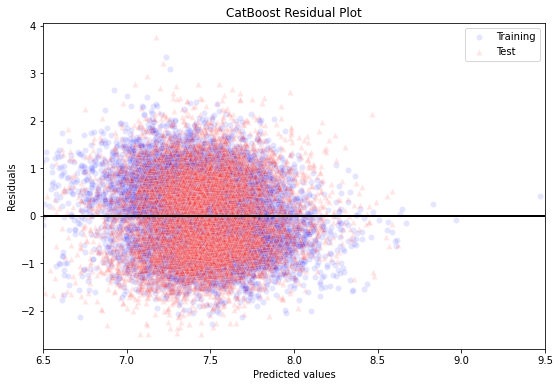

In [23]:
train_preds = cb_reg.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000], 
              y_val[:10000], val_preds[:10000], 
              title="CatBoost Residual Plot")

### 3.4 Analysis of feature importances and explainability of predictions

For interest, we can make use of our feature importances to plot the most important features used for our model:

In [24]:
feat_importances = cb_reg.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,cont8,7.924609
1,cont0,7.103257
2,cont9,5.582677
3,cont11,5.582283
4,cont13,5.511400
...,...,...
74,x7_A,0.000073
75,x6_G,0.000000
76,x6_H,0.000000
77,x7_I,0.000000


Lets plot the top 30 importances:

Text(0.5, 1.0, 'CatBoost features importance:')

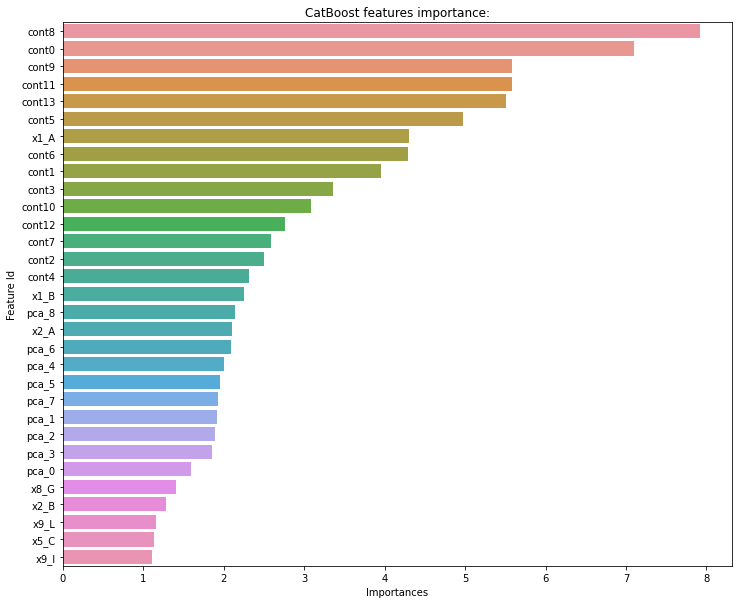

In [25]:
plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

Expanding on this concept further, we can make use of SHAP to visualise how our model is actually using each faeture to make predictions.

In [26]:
train_data = Pool(data=X_train, label=y_train)

val_data = Pool(data=X_val, label=y_val)

In [27]:
explainer = shap.TreeExplainer(cb_reg_1) 
shap_values = explainer.shap_values(train_data)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

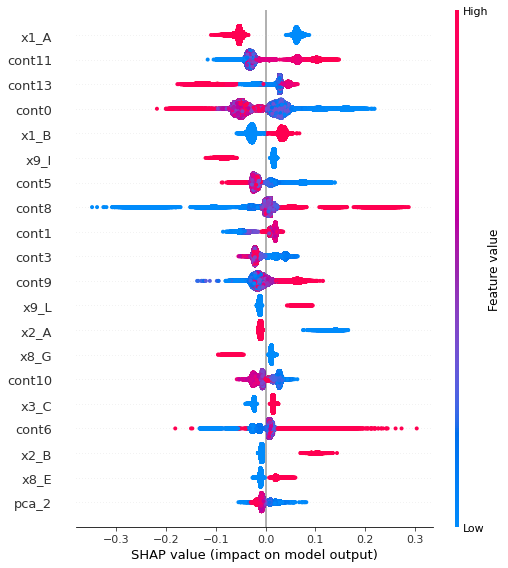

In [28]:
shap.summary_plot(shap_values, X_train)

Very pretty.... Now lets make our final model again, and submit a set of predictions on the test set.

<a id="test-preds"></a>
## 4. Final CatBoost Test Set Predictions using KFolds

We'll make a set of predictions on the test set through the use of KFolds cross validation. For each fold, we'll make predictions on the test set. 

We'll then take the overall average of these predictions across all models for the final test predictions, and submit them accordingly.

In [29]:
N_FOLDS = 5
k_folds = KFold(n_splits=N_FOLDS, shuffle=True)

# convert y values into appropriate form
y_array = y.values.reshape(-1, 1)

In [30]:
model_rmses = []
test_preds = np.zeros((X_test.shape[0], 1))

for train_idx, val_idx in tqdm(k_folds.split(X, y)):
    train_split = X.iloc[train_idx].copy()
    train_labels = y.iloc[train_idx].astype(np.float64).copy()
    val_split = X.iloc[val_idx].copy()
    val_labels = y.iloc[val_idx].astype(np.float64).copy()
    
    temp_model = CatBoostRegressor(**opt_catboost_params)
    
    # train model for 100 epochs with early stopping
    temp_model.fit(train_split, train_labels, 
               eval_set=(val_split, val_labels), 
               use_best_model=True,
               early_stopping_rounds=early_stop_rounds)
    
    # find log loss for out of fold val data
    model_val_preds = temp_model.predict(val_split)
    
    # calculate mean squared error on val sub-set preds
    fold_rmse = np.sqrt(mean_squared_error(model_val_preds, val_labels))
    model_rmses.append(fold_rmse)
    print(f'Current Fold validation RMSE: {fold_rmse:.4f}')
    
    # make predictions on test set for each fold
    temp_test_preds = temp_model.predict(X_test).reshape(-1, 1)
    test_preds += (temp_test_preds / N_FOLDS)

# convert results to np array
model_rmses = np.array(model_rmses)

0it [00:00, ?it/s]

0:	learn: 0.8871327	test: 0.8866212	best: 0.8866212 (0)	total: 18.2ms	remaining: 24m 12s
500:	learn: 0.8463602	test: 0.8531398	best: 0.8531398 (500)	total: 7.48s	remaining: 19m 46s
1000:	learn: 0.8334351	test: 0.8474606	best: 0.8474606 (1000)	total: 15s	remaining: 19m 41s
1500:	learn: 0.8245264	test: 0.8449856	best: 0.8449856 (1500)	total: 22s	remaining: 19m 8s
2000:	learn: 0.8174773	test: 0.8437573	best: 0.8437573 (2000)	total: 28.6s	remaining: 18m 36s
2500:	learn: 0.8114766	test: 0.8430877	best: 0.8430877 (2500)	total: 35.3s	remaining: 18m 12s
3000:	learn: 0.8059961	test: 0.8427015	best: 0.8427014 (2999)	total: 42s	remaining: 17m 58s
3500:	learn: 0.8009311	test: 0.8424565	best: 0.8424565 (3500)	total: 49.2s	remaining: 17m 56s
4000:	learn: 0.7961119	test: 0.8423285	best: 0.8423255 (3993)	total: 55.8s	remaining: 17m 40s
4500:	learn: 0.7914385	test: 0.8422720	best: 0.8422701 (4322)	total: 1m 2s	remaining: 17m 25s
5000:	learn: 0.7869648	test: 0.8422303	best: 0.8422251 (4982)	total: 1m 8s

1it [01:57, 117.07s/it]

0:	learn: 0.8877494	test: 0.8841457	best: 0.8841457 (0)	total: 18.1ms	remaining: 24m 11s
500:	learn: 0.8467140	test: 0.8519656	best: 0.8519656 (500)	total: 7.04s	remaining: 18m 36s
1000:	learn: 0.8339183	test: 0.8463919	best: 0.8463919 (1000)	total: 14.4s	remaining: 18m 56s
1500:	learn: 0.8250467	test: 0.8439748	best: 0.8439748 (1500)	total: 21.6s	remaining: 18m 49s
2000:	learn: 0.8180082	test: 0.8427603	best: 0.8427603 (2000)	total: 29s	remaining: 18m 49s
2500:	learn: 0.8119679	test: 0.8421131	best: 0.8421131 (2500)	total: 35.9s	remaining: 18m 32s
3000:	learn: 0.8064705	test: 0.8417749	best: 0.8417742 (2990)	total: 42.2s	remaining: 18m 2s
3500:	learn: 0.8012039	test: 0.8415687	best: 0.8415687 (3500)	total: 48.9s	remaining: 17m 49s
4000:	learn: 0.7962821	test: 0.8414513	best: 0.8414495 (3999)	total: 55.7s	remaining: 17m 37s
4500:	learn: 0.7915814	test: 0.8414000	best: 0.8413983 (4482)	total: 1m 2s	remaining: 17m 33s
5000:	learn: 0.7868720	test: 0.8413827	best: 0.8413638 (4905)	total: 1

2it [03:42, 110.06s/it]

0:	learn: 0.8863226	test: 0.8898822	best: 0.8898822 (0)	total: 17.8ms	remaining: 23m 41s
500:	learn: 0.8455186	test: 0.8580237	best: 0.8580237 (500)	total: 7.53s	remaining: 19m 55s
1000:	learn: 0.8327069	test: 0.8522946	best: 0.8522946 (1000)	total: 14.4s	remaining: 18m 53s
1500:	learn: 0.8241116	test: 0.8498168	best: 0.8498168 (1500)	total: 22.4s	remaining: 19m 32s
2000:	learn: 0.8169640	test: 0.8484457	best: 0.8484457 (2000)	total: 29.6s	remaining: 19m 12s
2500:	learn: 0.8108659	test: 0.8476857	best: 0.8476857 (2500)	total: 36.1s	remaining: 18m 38s
3000:	learn: 0.8054093	test: 0.8472272	best: 0.8472272 (3000)	total: 42.8s	remaining: 18m 16s
3500:	learn: 0.8001666	test: 0.8469673	best: 0.8469673 (3500)	total: 49.4s	remaining: 17m 59s
4000:	learn: 0.7952484	test: 0.8468871	best: 0.8468819 (3981)	total: 56.6s	remaining: 17m 54s
4500:	learn: 0.7905746	test: 0.8467925	best: 0.8467884 (4444)	total: 1m 3s	remaining: 17m 38s
5000:	learn: 0.7860428	test: 0.8467731	best: 0.8467638 (4652)	total

3it [05:21, 105.30s/it]

0:	learn: 0.8870455	test: 0.8869909	best: 0.8869909 (0)	total: 17.9ms	remaining: 23m 48s
500:	learn: 0.8460579	test: 0.8546492	best: 0.8546492 (500)	total: 7.46s	remaining: 19m 43s
1000:	learn: 0.8332880	test: 0.8490730	best: 0.8490730 (1000)	total: 14.6s	remaining: 19m 9s
1500:	learn: 0.8245367	test: 0.8465772	best: 0.8465772 (1500)	total: 22s	remaining: 19m 10s
2000:	learn: 0.8175511	test: 0.8453213	best: 0.8453213 (2000)	total: 28.8s	remaining: 18m 44s
2500:	learn: 0.8116059	test: 0.8446979	best: 0.8446979 (2500)	total: 35.3s	remaining: 18m 13s
3000:	learn: 0.8061102	test: 0.8442993	best: 0.8442990 (2999)	total: 42s	remaining: 17m 57s
3500:	learn: 0.8010991	test: 0.8440713	best: 0.8440713 (3500)	total: 48.7s	remaining: 17m 44s
4000:	learn: 0.7962473	test: 0.8439045	best: 0.8439045 (4000)	total: 55.7s	remaining: 17m 38s
4500:	learn: 0.7915524	test: 0.8438377	best: 0.8438320 (4485)	total: 1m 2s	remaining: 17m 28s
5000:	learn: 0.7869499	test: 0.8438152	best: 0.8438074 (4732)	total: 1m 

4it [07:02, 103.38s/it]

0:	learn: 0.8868856	test: 0.8876001	best: 0.8876001 (0)	total: 18.7ms	remaining: 24m 54s
500:	learn: 0.8456312	test: 0.8560283	best: 0.8560283 (500)	total: 7.47s	remaining: 19m 45s
1000:	learn: 0.8329909	test: 0.8505846	best: 0.8505846 (1000)	total: 14.7s	remaining: 19m 20s
1500:	learn: 0.8241337	test: 0.8480382	best: 0.8480382 (1500)	total: 22.1s	remaining: 19m 18s
2000:	learn: 0.8170492	test: 0.8467741	best: 0.8467741 (2000)	total: 29.3s	remaining: 19m 3s
2500:	learn: 0.8109858	test: 0.8460490	best: 0.8460490 (2500)	total: 36.2s	remaining: 18m 41s
3000:	learn: 0.8053726	test: 0.8456113	best: 0.8456113 (3000)	total: 42.5s	remaining: 18m 10s
3500:	learn: 0.8003248	test: 0.8453956	best: 0.8453956 (3500)	total: 49.1s	remaining: 17m 53s
4000:	learn: 0.7954655	test: 0.8452727	best: 0.8452727 (4000)	total: 56.1s	remaining: 17m 46s
4500:	learn: 0.7907248	test: 0.8451982	best: 0.8451954 (4472)	total: 1m 2s	remaining: 17m 30s
5000:	learn: 0.7861606	test: 0.8452044	best: 0.8451780 (4677)	total:

5it [08:41, 104.36s/it]


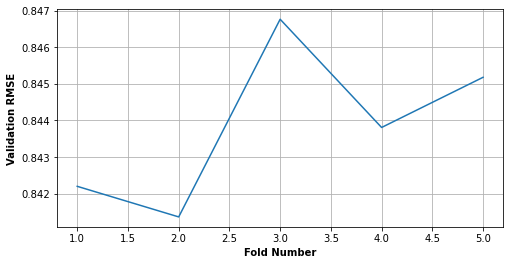

In [31]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, model_rmses.shape[0]+1), y=model_rmses)
plt.xlabel("Fold Number", weight='bold')
plt.ylabel("Validation RMSE", weight='bold')
plt.grid()
plt.show()

Final model and predictions on test set:

Great, we now have our final predictions, and so can submit these to the competition:

In [32]:
submission_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
submission_df['target'] = test_preds
submission_df.to_csv('submission.csv', index=False)

As shown, CatBoost can have remarkable performance, even without lots of manual hyper-paramter tuning. This is due to its built in optimisation performed during training.

Many thanks for reading through this notebook - I hope you enjoyed!